In [1]:
!pip install iterative-stratification

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Library Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

from time import time
import random as r

from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import warnings
warnings.filterwarnings("ignore")

# Helper Functions

In [4]:
def breaker():
  print("\n" + 30*"-" + "\n")

def head(x, no_of_ele=5):
    breaker()
    print(x[:no_of_ele])
    breaker()

def preprocess(x):
  df = x.copy()
  df.iloc[:, 1] = df.iloc[:, 1].map({"trt_cp" : 0, "ctl_vehicle" : 1})
  df.iloc[:, 3] = df.iloc[:, 3].map({"D1" : 0, "D2" : 1})
  return df

def log_loss_metric(y_true, y_pred, num_classes=206):
  metric = []
  for i in range(num_classes):
    metric.append(log_loss(y_true[:, i], y_pred[:, i], labels=[0, 1], eps=1e-15))
  return sum(metric)/num_classes

datapath = "/content/gdrive/My Drive/Datasets/MoA/"
# Try using log_loss_metric as loss to be optimized.

# Data Handling

**Input**

In [5]:
tr_feat = pd.read_csv("/content/gdrive/My Drive/Datasets/MoA/train.csv")
tr_lbls = pd.read_csv("/content/gdrive/My Drive/Datasets/MoA/train_targets_s.csv")
tr_lbls_ns = pd.read_csv("/content/gdrive/My Drive/Datasets/MoA/train_targets_ns.csv")

breaker()
print(tr_feat.shape)
breaker()
print(tr_lbls.shape)
breaker()
print(tr_lbls_ns.shape)
breaker()


------------------------------

(23814, 876)

------------------------------

(23814, 207)

------------------------------

(23814, 403)

------------------------------



**Top Features**

In [6]:
top_feats = [  1,   2,   3,   4,   5,   6,   7,   9,  11,  14,  15,  16,  17,
              18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  29,  30,  31,
              32,  33,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  46,
              47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,  60,
              61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
              74,  75,  76,  78,  79,  80,  81,  82,  83,  84,  86,  87,  88,
              89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
              102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
              115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128,
              129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143,
              144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157,
              158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
              171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
              184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197,
              198, 199, 200, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212,
              213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226,
              227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
              240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
              254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
              267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
              281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294,
              295, 296, 298, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
              310, 311, 312, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
              324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
              337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
              350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
              363, 364, 365, 366, 367, 368, 369, 370, 371, 374, 375, 376, 377,
              378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 390, 391,
              392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
              405, 406, 407, 408, 409, 411, 412, 413, 414, 415, 416, 417, 418,
              419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
              432, 434, 435, 436, 437, 438, 439, 440, 442, 443, 444, 445, 446,
              447, 448, 449, 450, 453, 454, 456, 457, 458, 459, 460, 461, 462,
              463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
              476, 477, 478, 479, 481, 482, 483, 484, 485, 486, 487, 488, 489,
              490, 491, 492, 493, 494, 495, 496, 498, 500, 501, 502, 503, 505,
              506, 507, 509, 510, 511, 512, 513, 514, 515, 518, 519, 520, 521,
              522, 523, 524, 525, 526, 527, 528, 530, 531, 532, 534, 535, 536,
              538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 549, 550, 551,
              552, 554, 557, 559, 560, 561, 562, 565, 566, 567, 568, 569, 570,
              571, 572, 573, 574, 575, 577, 578, 580, 581, 582, 583, 584, 585,
              586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599,
              600, 601, 602, 606, 607, 608, 609, 611, 612, 613, 615, 616, 617,
              618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630,
              631, 632, 633, 634, 635, 636, 637, 638, 639, 641, 642, 643, 644,
              645, 646, 647, 648, 649, 650, 651, 652, 654, 655, 656, 658, 659,
              660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672,
              673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685,
              686, 687, 688, 689, 691, 692, 693, 694, 695, 696, 697, 699, 700,
              701, 702, 704, 705, 707, 708, 709, 710, 711, 713, 714, 716, 717,
              718, 720, 721, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732,
              733, 734, 735, 737, 738, 739, 740, 742, 743, 744, 745, 746, 747,
              748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 759, 760, 761,
              762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774,
              775, 776, 777, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788,
              789, 790, 792, 793, 794, 795, 796, 797, 798, 800, 801, 802, 803,
              804, 805, 806, 808, 809, 811, 813, 814, 815, 816, 817, 818, 819,
              821, 822, 823, 825, 826, 827, 828, 829, 830, 831, 832, 834, 835,
              837, 838, 839, 840, 841, 842, 845, 846, 847, 848, 850, 851, 852,
              854, 855, 856, 858, 859, 860, 861, 862, 864, 866, 867, 868, 869,
              870, 871, 872, 873, 874]

**Pre-processing**

In [7]:
features = tr_feat.copy()
labels   = tr_lbls.copy()

features = preprocess(features)

labels   = labels.loc[features["cp_type"] == 0].reset_index(drop=True)
features = features.loc[features["cp_type"] == 0].reset_index(drop=True)

breaker()
print("Features Matrix Shape :", repr(features.shape))
breaker()
print("Labels Matrix Shape   :", repr(labels.shape))
breaker()


------------------------------

Features Matrix Shape : (21948, 876)

------------------------------

Labels Matrix Shape   : (21948, 207)

------------------------------



**Creating Train and Test Sets**

In [8]:
X, X_test, y, y_test = train_test_split(features, labels, test_size=1948, shuffle=True, random_state=0)

X, X_test, y, y_test = X.values, X_test.values, y.values, y_test.values

X, X_test, y, y_test = X[:, top_feats], X_test[:, top_feats], y[:, 1:], y_test[:, 1:]

X, X_test, y, y_test = X.astype(float), X_test.astype(float), y.astype(float), y_test.astype(float)

In [9]:
num_features = X.shape[1]
num_classes  = y.shape[1]
num_obs_test = y_test.shape[0]

del tr_feat, tr_lbls

**Dataset Template**

In [10]:
class DS(Dataset):
  def __init__(this, X=None, y=None, mode="train"):
    this.mode = mode
    this.X = X
    if mode == "train":
      this.y = y
  
  def __len__(this):
    return this.X.shape[0]

  def __getitem__(this, idx):
    if this.mode == "train":
      return torch.FloatTensor(this.X[idx]), torch.FloatTensor(this.y[idx])
    else:
      return torch.FloatTensor(this.X[idx])

# ANN

**Config**

In [11]:
class CFG():
  tr_batch_size = 128
  va_batch_size = 128
  ts_batch_size = 128

  epochs = 50

  IL = num_features
  # Baseline Parameters
  #HL_1 = [2048, 1024]
  #HL_2 = [512, 512, 512]

  HL_1 = [2048, 1024]
  HL_2 = [2048, 1024, 512]
  OL = num_classes
  n_folds = 10

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cfg = CFG()

ts_data_setup = DS(X_test, None, "test")
ts_data = DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)

metrics = []

**Setup**

In [12]:
class ANN(nn.Module):
  def __init__(this, IL=None, HL=None, OL=None):
    super(ANN, this).__init__()

    this.HL = HL
    this.DP1 = nn.Dropout(p=0.2)
    this.DP2 = nn.Dropout(p=0.5)

    if len(HL) == 2:
      this.BN1 = nn.BatchNorm1d(IL)
      this.FC1 = WN(nn.Linear(IL, HL[0]))

      this.BN2 = nn.BatchNorm1d(HL[0])
      this.FC2 = WN(nn.Linear(HL[0], HL[1]))

      this.BN3 = nn.BatchNorm1d(HL[1])
      this.FC3 = WN(nn.Linear(HL[1], OL))
    elif len(HL) == 3:
      this.BN1 = nn.BatchNorm1d(IL)
      this.FC1 = WN(nn.Linear(IL, HL[0]))

      this.BN2 = nn.BatchNorm1d(HL[0])
      this.FC2 = WN(nn.Linear(HL[0], HL[1]))

      this.BN3 = nn.BatchNorm1d(HL[1])
      this.FC3 = WN(nn.Linear(HL[1], HL[2]))

      this.BN4 = nn.BatchNorm1d(HL[2])
      this.FC4 = WN(nn.Linear(HL[2], OL))
    else:
      raise NotImplementedError("Only Allows Networks of Depth 2 or 3")

  def getOptimizer(this):
    return optim.Adam(this.parameters(), lr=1e-3, weight_decay=1e-5)
    
  def forward(this, x):
    if len(this.HL) == 2:
      x = this.BN1(x)
      x = this.DP1(x)
      x = F.relu(this.FC1(x))
      x = this.BN2(x)
      x = this.DP2(x)
      x = F.relu(this.FC2(x))
      x = this.BN3(x)
      x = this.DP2(x)
      x = torch.sigmoid(this.FC3(x))
      return x
    else:
      x = this.BN1(x)
      x = this.DP1(x)
      x = F.relu(this.FC1(x))
      x = this.BN2(x)
      x = this.DP2(x)
      x = F.relu(this.FC2(x))
      x = this.BN3(x)
      x = this.DP2(x)
      x = F.relu(this.FC3(x))
      x = this.BN4(x)
      x = this.DP2(x)
      x = torch.sigmoid(this.FC4(x))
      return x

**ANN Helpers**

In [13]:
def train_fn(X=None, y=None, n_folds=None, HL_to_use=None):
  breaker()
  print("Training ...")
  breaker()

  LP = []
  names = []
  bestLoss = {"train" : np.inf, "valid" : np.inf}
  fold = 0

  start_time = time()
  for tr_idx, va_idx in MultilabelStratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0).split(X, y):
    print("Processing Fold {fold} ...".format(fold=fold+1))

    X_train, X_valid, y_train, y_valid = X[tr_idx], X[va_idx], y[tr_idx], y[va_idx]

    tr_data_setup = DS(X_train, y_train)
    va_data_setup = DS(X_valid, y_valid)

    dataloaders = {"train" : DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(0)),
                   "valid" : DL(va_data_setup, batch_size=cfg.va_batch_size, shuffle=False)
                  }

    torch.manual_seed(0)
    model = ANN(cfg.IL, HL_to_use, cfg.OL)
    model.to(cfg.device)

    optimizer = model.getOptimizer()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, eps=1e-6, verbose=True)

    for e in range(cfg.epochs):
      epochLoss = {"train" : 0, "valid" : 0}
      for phase in ["train", "valid"]:
        if phase == "train":
          model.train()
        else:
          model.eval()
        lossPerPass = 0

        for feats, label in dataloaders[phase]:
          feats, label = feats.to(cfg.device), label.to(cfg.device)

          optimizer.zero_grad()
          with torch.set_grad_enabled(phase == "train"):
            output = model(feats)
            loss   = nn.BCELoss()(output, label)
            if phase == "train":
              loss.backward()
              optimizer.step()
          lossPerPass = (loss.item()/label.shape[0])
        epochLoss[phase] = lossPerPass
      LP.append(epochLoss)
      scheduler.step(epochLoss["valid"])
      if epochLoss["valid"] < bestLoss["valid"]:
        bestLoss = epochLoss
        name = "Model_{id}_Fold_{fold}.pt".format(id=len(HL_to_use), fold=fold)
        names.append(name)
        torch.save(model.state_dict(), datapath+name)
    fold += 1

  breaker()
  print("Time Taken to Train {n} folds for {e} epochs : {:.2f} minutes".format((time()-start_time)/60, n=n_folds, e=cfg.epochs))
  breaker()
  print("Best Loss :", repr(bestLoss))
  breaker()
  print("Training Completed")
  breaker()
    
  return LP, names, model

def eval_fn(model=None, names=None, dataloader=None):
  y_pred = np.zeros((num_obs_test, num_classes))

  for name in names:
    Pred = torch.zeros(cfg.ts_batch_size, num_classes).to(cfg.device)
    model.load_state_dict(torch.load(datapath+name))
    model.eval()
    for feat in dataloader:
      feat = feat.to(cfg.device)
      with torch.no_grad():
        Prob = model(feat)
      Pred = torch.cat((Pred, Prob), dim=0)
    Pred = Pred[cfg.ts_batch_size:]
    Pred = Pred.cpu().numpy()
    y_pred = np.add(y_pred, Pred)
  y_pred = np.divide(y_pred, len(names))
  return y_pred

# 7-Fold Cross Validation

**Configuration 1**


------------------------------

Training ...

------------------------------

Processing Fold 1 ...
Epoch    22: reducing learning rate of group 0 to 1.0000e-04.
Epoch    26: reducing learning rate of group 0 to 1.0000e-05.
Epoch    30: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 2 ...
Epoch    34: reducing learning rate of group 0 to 1.0000e-04.
Epoch    38: reducing learning rate of group 0 to 1.0000e-05.
Epoch    42: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 3 ...
Epoch    23: reducing learning rate of group 0 to 1.0000e-04.
Epoch    30: reducing learning rate of group 0 to 1.0000e-05.
Epoch    42: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 4 ...
Epoch    28: reducing learning rate of group 0 to 1.0000e-04.
Epoch    35: reducing learning rate of group 0 to 1.0000e-05.
Epoch    41: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 5 ...
Epoch    30: reducing learning rate of group 0 to 1.0000e-04.
Epoch

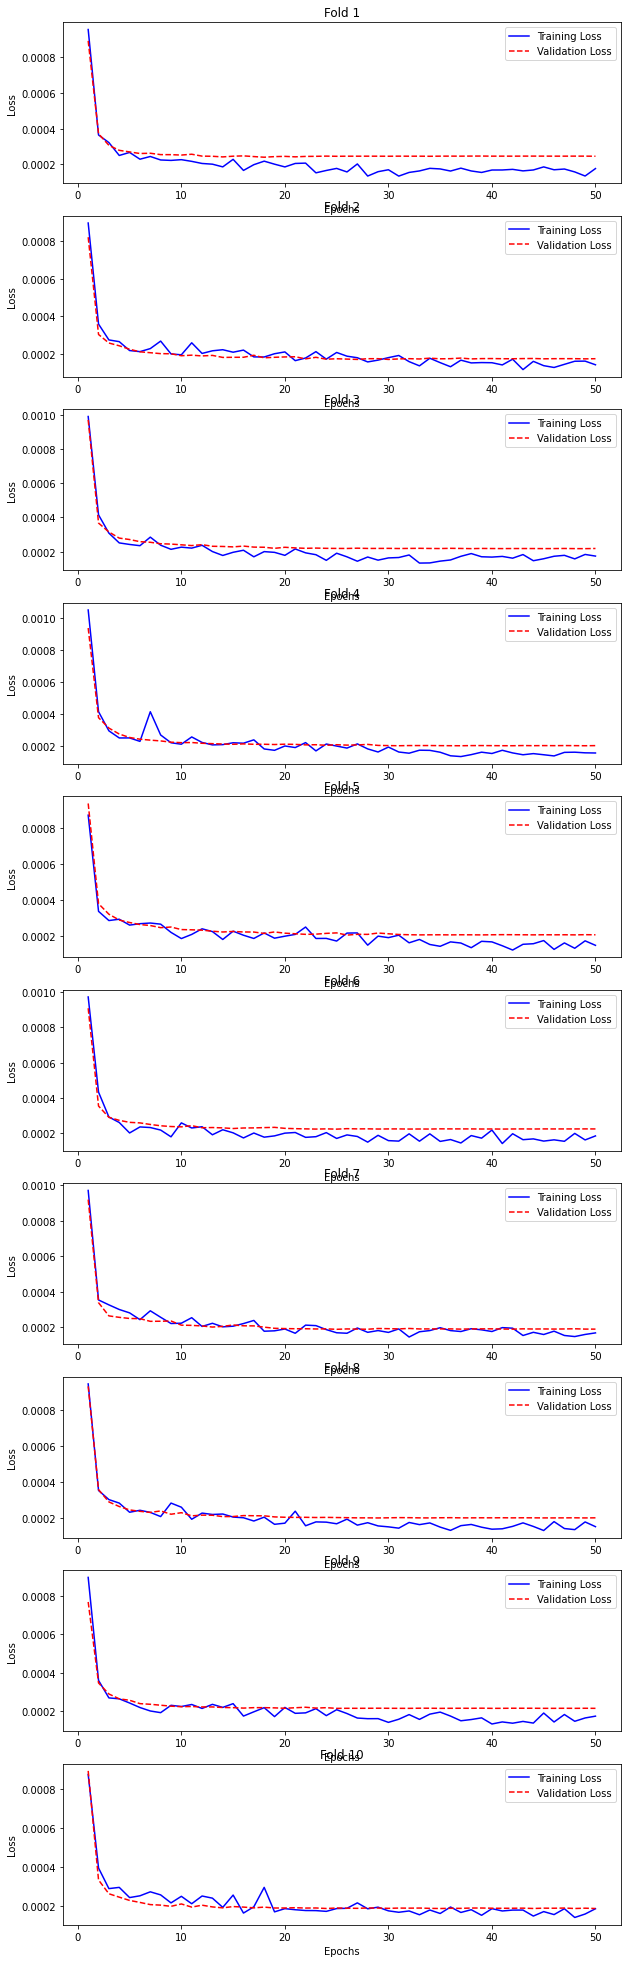


------------------------------

Log Loss : 0.01681

------------------------------



In [14]:
LP_1, names_1, Network_1 = train_fn(X=X, y=y, n_folds=cfg.n_folds, HL_to_use=cfg.HL_1)

LPV = []
LPT = []
for i in range(len(LP_1)):
  LPT.append(LP_1[i]["train"])
  LPV.append(LP_1[i]["valid"])

xAxis = [i+1 for i in range(cfg.epochs)]
plt.figure(figsize=(10, 35))
for fold in range(cfg.n_folds):
    plt.subplot(cfg.n_folds, 1, fold+1)
    plt.plot(xAxis, LPT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Loss")
    plt.plot(xAxis, LPV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()

y_pred_1 = eval_fn(Network_1, names_1, ts_data)

breaker()
print("Log Loss : {:.5f}".format(log_loss_metric(y_test, y_pred_1)))
breaker()

metrics.append(log_loss_metric(y_test, y_pred_1))

**Configuration 2**



------------------------------

Training ...

------------------------------

Processing Fold 1 ...
Epoch    23: reducing learning rate of group 0 to 1.0000e-04.
Epoch    27: reducing learning rate of group 0 to 1.0000e-05.
Epoch    36: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 2 ...
Epoch    28: reducing learning rate of group 0 to 1.0000e-04.
Processing Fold 3 ...
Epoch    29: reducing learning rate of group 0 to 1.0000e-04.
Epoch    42: reducing learning rate of group 0 to 1.0000e-05.
Epoch    48: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 4 ...
Epoch    22: reducing learning rate of group 0 to 1.0000e-04.
Epoch    35: reducing learning rate of group 0 to 1.0000e-05.
Epoch    39: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 5 ...
Epoch    33: reducing learning rate of group 0 to 1.0000e-04.
Epoch    44: reducing learning rate of group 0 to 1.0000e-05.
Epoch    48: reducing learning rate of group 0 to 1.0000e-06.
Proce

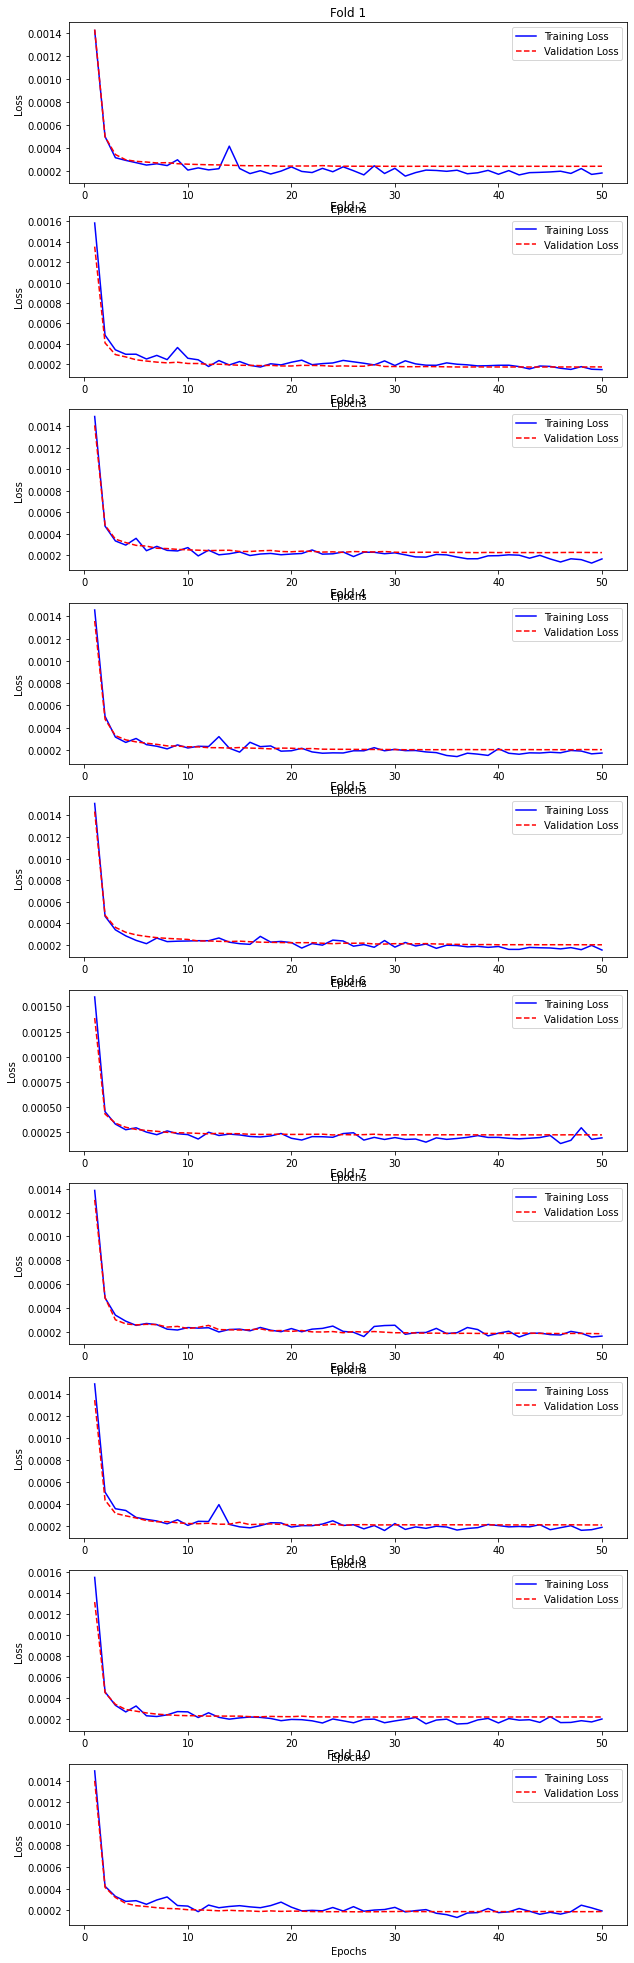


------------------------------

Log Loss : 0.01662

------------------------------



In [15]:
LP_2, names_2, Network_2 = train_fn(X=X, y=y, n_folds=cfg.n_folds, HL_to_use=cfg.HL_2)

LPV = []
LPT = []
for i in range(len(LP_2)):
  LPT.append(LP_2[i]["train"])
  LPV.append(LP_2[i]["valid"])

xAxis = [i+1 for i in range(cfg.epochs)]
plt.figure(figsize=(10, 35))
for fold in range(cfg.n_folds):
    plt.subplot(cfg.n_folds, 1, fold+1)
    plt.plot(xAxis, LPT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Loss")
    plt.plot(xAxis, LPV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()

y_pred_2 = eval_fn(Network_2, names_2, ts_data)

breaker()
print("Log Loss : {:.5f}".format(log_loss_metric(y_test, y_pred_2)))
breaker()

metrics.append(log_loss_metric(y_test, y_pred_2))

In [16]:
def ensemble_eval_fn(model_1=None, model_2=None, names_1=None, names_2=None, dataloader=None):
  y_pred_1 = np.zeros((num_obs_test, num_classes))
  y_pred_2 = np.zeros((num_obs_test, num_classes))

  for name in names_1:
    Pred = torch.zeros(cfg.ts_batch_size, num_classes).to(cfg.device)
    model_1.load_state_dict(torch.load(datapath+name))
    model_1.eval()
    for feat in dataloader:
      feat = feat.to(cfg.device)
      with torch.no_grad():
        Prob = model_1(feat)
      Pred = torch.cat((Pred, Prob), dim=0)
    Pred = Pred[cfg.ts_batch_size:]
    Pred = Pred.cpu().numpy()
    y_pred_1 = np.add(y_pred_1, Pred)
  y_pred_1 = np.divide(y_pred_1, len(names_1))

  for name in names_2:
    Pred = torch.zeros(cfg.ts_batch_size, num_classes).to(cfg.device)
    model_2.load_state_dict(torch.load(datapath+name))
    model_2.eval()
    for feat in dataloader:
      feat = feat.to(cfg.device)
      with torch.no_grad():
        Prob = model_2(feat)
      Pred = torch.cat((Pred, Prob), dim=0)
    Pred = Pred[cfg.ts_batch_size:]
    Pred = Pred.cpu().numpy()
    y_pred_2 = np.add(y_pred_2, Pred)
  y_pred_2 = np.divide(y_pred_2, len(names_2))

  y_pred = np.divide(np.add(y_pred_1, y_pred_2), 2)
  return y_pred

ensemble_y_pred = ensemble_eval_fn(Network_1, Network_2, names_1, names_2, ts_data)

breaker()
print("Log Loss : {:.5f}".format(log_loss_metric(y_test, ensemble_y_pred)))
breaker()


------------------------------

Log Loss : 0.01660

------------------------------

